# SUMMARIZING IMMUNE CELLS
## Sid Gurajala
## Last Updated: 03/21/2024

In [1]:
library(Seurat)
library(dplyr) 
library(tidyr)
library(viridis)
library(stringr)
library(pheatmap)
library(presto)
library(pals)
library(parallel)
library(harmony)
library(cowplot)
library(singlecellmethods)
library(ggplot2)
library(lisi) 
source("/data/srlab/anathan/scripts/scseq_utils.R")
library(parallel)
library('lme4', lib.loc = "/PHShome/ssg34/.conda/envs/jupy/lib/R/library")
library(glmmTMB, lib.loc ="/PHShome/ssg34/.conda/envs/jupy/lib/R/library")
.libPaths("/PHShome/ssg34/.conda/envs/plswork/lib/R/library")


pivot_wilcox_expr <- function(wilcox_obj) {
    df <- wilcox_obj %>% select(group, feature, avgExpr) %>% 
                    pivot_wider(names_from = 'feature', values_from = 'avgExpr') %>% data.frame()
    rownames(df) <- df$group
    df <- df %>% select(-group) %>% as.matrix()
    return(df)
}

pivot_wilcox_logFC <- function(wilcox_obj) {
    df <- wilcox_obj %>% select(group, feature, logFC) %>% 
                    pivot_wider(names_from = 'feature', values_from = 'logFC') %>% data.frame()
    rownames(df) <- df$group
    df <- df %>% select(-group) %>% as.matrix()
    return(df)
}

plot_shuffled_features <- function(input_df, input_norm, feature, pct, pt_size) {
    
max.cutoff = quantile(input_norm[feature, input_df$cell], pct)
min.cutoff = quantile(input_norm[feature, input_df$cell], 1-pct)

plot_df <- input_df 
    
plot_df$norm_expression <- input_norm[feature, input_df$cell]
    
plot_df <- plot_df %>% 
                mutate(norm_expression = ifelse(norm_expression < min.cutoff, min.cutoff, norm_expression)) %>%
                mutate(norm_expression = ifelse(norm_expression > max.cutoff, max.cutoff, norm_expression)) 

p <- ggplot() +
        geom_point(
            data = plot_df[sample(nrow(plot_df)), ] %>% 
                      select(hUMAP1, hUMAP2, norm_expression), 
            aes(x = hUMAP1, y = hUMAP2, color = norm_expression),
            size = pt_size, stroke = 0.0001, shape = 20) +
      scale_color_viridis(name = "Expression") +
      labs(x="", y="", title = feature)+
      theme_classic(base_size = 20)+
      #facet_wrap(~dataset)+
      theme(
        legend.text = element_text(size = 10), 
        legend.title = element_text(size = 12),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=25, face="bold.italic", hjust = 0.5),
        strip.text.x = element_text(size = 18),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          axis.line = element_blank()) 
return(p)
}

vargenes_vst <- function(object, groups, topn, loess.span = 0.3) {
    clip.max <- sqrt(ncol(object))

    N <- ncol(object)
    if (missing(groups)) {
        groups <- rep('A', N)
    }
    
    res <- split(seq_len(N), groups) %>% lapply(function(idx) {
        object_group <- object[, idx]
        ## row means
        hvf.info <- data.frame(
          symbol = rownames(object_group), 
          mean = Matrix::rowMeans(object_group)
        )

        ## row vars
        hvf.info$variance <- rowVars(object_group, hvf.info$mean)

        ## initialize
        hvf.info$variance.expected <- 0
        hvf.info$variance.standardized <- 0

        not.const <- hvf.info$variance > 0

        ## loess curve fit 
        suppressWarnings({
            fit <- loess(formula = log10(variance) ~ log10(mean), 
                data = hvf.info[not.const, ], span = loess.span)            
        })

        ## extract fitted variance 
        hvf.info$variance.expected[not.const] <- 10^fit$fitted

        ## get row standard deviations after clipping
        hvf.info$variance.standardized <- rowVarsStd(
            object_group, 
            hvf.info$mean, 
            sqrt(hvf.info$variance.expected), 
            clip.max
        )

        hvf.info <- hvf.info %>% 
#             tibble::rownames_to_column('symbol') %>% 
            arrange(-variance.standardized) %>% 
            tibble::rowid_to_column('rank') %>% 
            transform(group = unique(groups[idx]))

        return(hvf.info)        
    })
    
    
    if (missing(topn)) {
        ## MODE 1: return table 
        res <- Reduce(rbind, res) %>% 
            dplyr::select(group, symbol, rank, everything())

        if (length(unique(res$group)) == 1) {
            res$group <- NULL
        }
    } else {
        ## MODE 2: return genes
        res <- lapply(res, function(x) head(x, topn)$symbol)
    }
    return(res)
}
                      
MASC.me <- function(dataset, cluster, contrast, random_effects = NULL, fixed_effects = NULL,
                 verbose = FALSE, save_models = FALSE, save_model_dir = NULL, weights = NULL) {
  # Generate design matrix from cluster assignments
  cluster <- as.character(cluster)
  designmat <- model.matrix(~ cluster + 0, data.frame(cluster = cluster))
  dataset <- cbind(designmat, dataset)

  # Convert cluster assignments to string
  cluster <- as.character(cluster)
  # Prepend design matrix generated from cluster assignments
  designmat <- model.matrix(~ cluster + 0, data.frame(cluster = cluster))
  dataset <- cbind(designmat, dataset)
  # Create output list to hold results
  res <- vector(mode = "list", length = length(unique(cluster)))
  names(res) <- attributes(designmat)$dimnames[[2]]

  # Create model formulas
  if (!is.null(fixed_effects) && !is.null(random_effects)) {
    model_rhs <- paste0(c(paste0(fixed_effects, collapse = " + "),
                          paste0("(1|", random_effects, ")", collapse = " + ")),
                        collapse = " + ")
    if (verbose == TRUE) {
      message(paste("Using null model:", "cluster ~", model_rhs))
    }
  } else if (!is.null(fixed_effects) && is.null(random_effects)) {
    model_rhs <- paste0(fixed_effects, collapse = " + ")
    if (verbose == TRUE) {
      message(paste("Using null model:", "cluster ~", model_rhs))
      # For now, do not allow models without mixed effects terms
      stop("No random effects specified")
    }
  } else if (is.null(fixed_effects) && !is.null(random_effects)) {
    model_rhs <- paste0("(1|", random_effects, ")", collapse = " + ")
    if (verbose == TRUE) {
      message(paste("Using null model:", "cluster ~", model_rhs))
    }
  } else {
    model_rhs <- "1" # only includes intercept
    if (verbose == TRUE) {
      message(paste("Using null model:", "cluster ~", model_rhs))
      stop("No random or fixed effects specified")
    }
  }

  # Initialize list to store model objects for each cluster
  cluster_models <- vector(mode = "list",
                           length = length(attributes(designmat)$dimnames[[2]]))
  names(cluster_models) <- attributes(designmat)$dimnames[[2]]

  # Run nested mixed-effects models for each cluster
  for (i in seq_along(attributes(designmat)$dimnames[[2]])) {
    test_cluster <- attributes(designmat)$dimnames[[2]][i]
    if (verbose == TRUE) {
      message(paste("Creating logistic mixed models for", test_cluster))
    }
    null_fm <- as.formula(paste0(c(paste0(test_cluster, " ~ 1 + "),
                                   model_rhs), collapse = ""))
    full_fm <- as.formula(paste0(c(paste0(test_cluster, " ~ ", contrast, " + "),
                                   model_rhs), collapse = ""))
    # Run null and full mixed-effects models
    null_model <- lme4::glmer(formula = null_fm, data = dataset,
                              family = binomial, nAGQ = 1, verbose = 0,
                              control = glmerControl(optimizer = "bobyqa"), weights = weights)
 #   print(summary(null_model))
    full_model <- lme4::glmer(formula = full_fm, data = dataset,
                              family = binomial, nAGQ = 1, verbose = 0,
                              control = glmerControl(optimizer = "bobyqa"), weights = weights)
 #   print(summary(full_model))
    flush.console()
    model_lrt <- anova(null_model, full_model)
    # calculate confidence intervals for contrast term beta
    contrast_lvl2 <- paste0(contrast, levels(dataset[[contrast]])[2])
    contrast_ci <- confint.merMod(full_model, method = "Wald",
                                  parm = contrast_lvl2)
    # Save model objects to list
    cluster_models[[i]]$null_model <- null_model
    cluster_models[[i]]$full_model <- full_model
    cluster_models[[i]]$model_lrt <- model_lrt
    cluster_models[[i]]$confint <- contrast_ci
  }

  # Organize results into output dataframe
  output <- data.frame(cluster = attributes(designmat)$dimnames[[2]],
                       size = colSums(designmat))
  output$model.pvalue <- sapply(cluster_models, function(x) x$model_lrt[["Pr(>Chisq)"]][2])
  output[[paste(contrast_lvl2, "OR", sep = ".")]] <- sapply(cluster_models, function(x) exp(fixef(x$full)[[contrast_lvl2]]))
  output[[paste(contrast_lvl2, "OR", "95pct.ci.lower", sep = ".")]] <- sapply(cluster_models, function(x) exp(x$confint[contrast_lvl2, "2.5 %"]))
  output[[paste(contrast_lvl2, "OR", "95pct.ci.upper", sep = ".")]] <- sapply(cluster_models, function(x) exp(x$confint[contrast_lvl2, "97.5 %"]))

  # Return MASC results and save models if specified
  if (save_models == TRUE) {
    saveModelObj(cluster_models, save_dir = save_model_dir)
    return(output)
  } else {
    return(output)
  }
}

pseudobulk <- function(individual, meta, norm) {
    cells <- meta %>% filter(sample == individual) %>% pull(cell)
    if (length(cells) > 2) {
        pb <- rowMeans(norm[, cells])
        pb <- c(pb, individual)
        names(pb) <- c(rownames(norm), 'sample')
        return(pb)
    }
}



de <- function(feature, df) {
    model_df <- df %>% select(feature, sample, Type, avg_count, avg_mt) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.10 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + Type, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['TypeLN', 'Estimate']
        SE <- summary(m_1)$coefficients['TypeLN', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}  
                                                                              

cna_cor <- function(gene, meta, norm) {
    if (sum(norm[gene, meta$cell]) > 0.1 * nrow(meta)) {
        cor_test <- cor.test(meta$ncorr, norm[gene, meta$cell])
        res <- c(gene, cor_test$estimate, cor_test$p.value)
    }
    else {
        res <- c(gene, NA, NA)
    }
    return(res)
}

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

Loading required package: Rcpp

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘pals’


The following objects are masked from ‘package:viridis’:

    cividis, inferno, magma, plasma, turbo, viridis


The following objects are masked from ‘package:viridisLite’:

    cividis, inferno, magma, plasma, turbo, viridis



Attaching package: ‘singlecellmethods’


The following object is masked from ‘package:SeuratObject’:

    rowMeans


The following object is masked from ‘package:base’:

    rowMeans


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘p

# B_PLASMA

In [2]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/BP_clusterQCd_cellstate_meta_annotations_09232022.rds')
qcd_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/BP_clusterQCd_norm_09232022.rds')

In [38]:
sn_control <- qcd_meta %>% filter(dataset == "snRNAseq", Type == "Control") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sn_control = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sn_control)
sn_LN <- qcd_meta %>% filter(dataset == "snRNAseq", Type == "LN") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sn_LN = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sn_LN)
sc_control <- qcd_meta %>% filter(dataset == "scRNAseq", Type == "Control") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sc_control = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sc_control)
sc_LN <- qcd_meta %>% filter(dataset == "scRNAseq", Type == "LN") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sc_LN = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sc_LN)
merged <- sc_LN %>% left_join(sc_control) %>% left_join(sn_LN) %>% left_join(sn_control)
merged[is.na(merged)] <- "0 (0)"

Joining, by = "new_cluster_number"
Joining, by = "new_cluster_number"
Joining, by = "new_cluster_number"


In [43]:
write.csv(merged, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/bplasma_summary_04152024.csv', quote = FALSE, row.names = FALSE)

## Fine Grain Cell Types Figure

### Single Cell UMAP, Single Nuclear UMAP

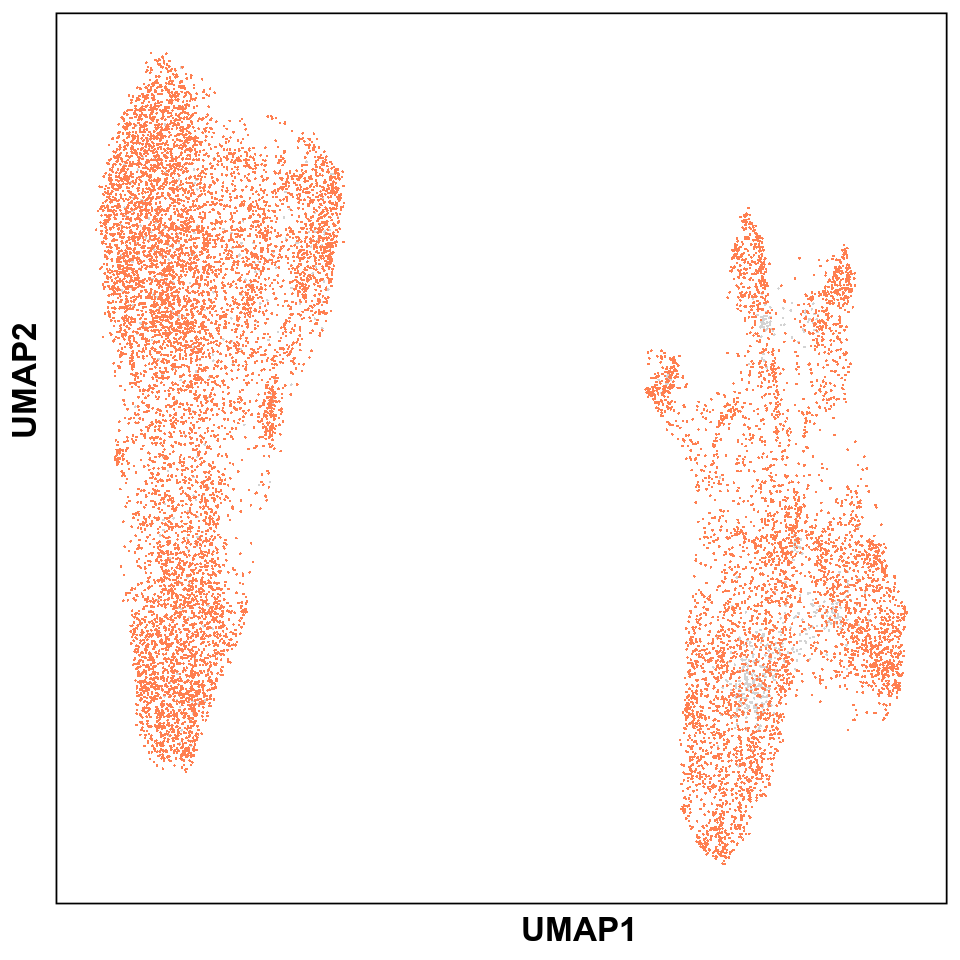

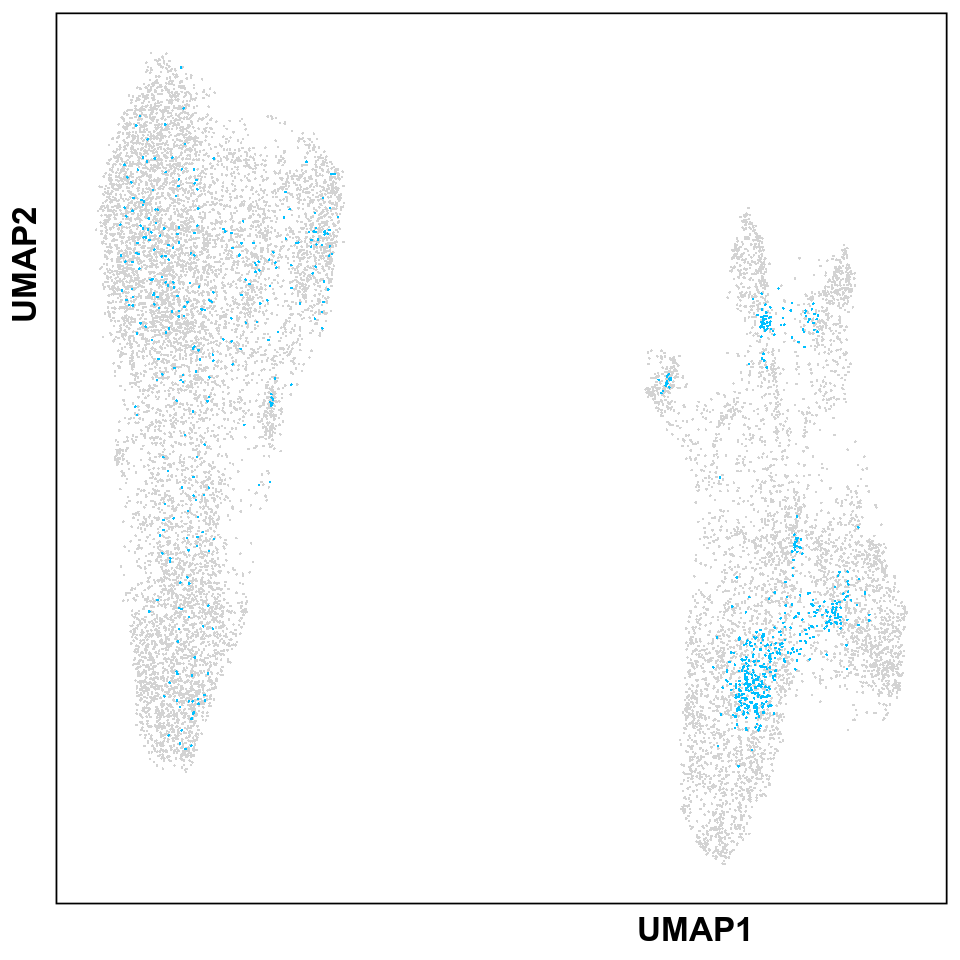

In [169]:
options(repr.plot.height = 8, repr.plot.width = 8)
ggplot() +
  geom_point(
    data=select(qcd_meta, c(hUMAP1, hUMAP2, dataset)),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "lightgrey"
  ) + 
  geom_point(
    data=qcd_meta %>% filter(dataset == "scRNAseq") %>% select(hUMAP1, hUMAP2),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "coral"
  ) +
theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
        #  plot.title = element_text(hjust = 0.5, 
        #                            size = 18, 
        #                            face = "bold"),
          axis.title = element_text(hjust = 0.6, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +     labs(x = "UMAP1", y = "UMAP2") 


ggplot() +
  geom_point(
    data=select(qcd_meta, c(hUMAP1, hUMAP2, dataset)),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "lightgrey"
  ) + 
  geom_point(
    data=qcd_meta %>% filter(dataset == "snRNAseq") %>% select(hUMAP1, hUMAP2),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "deepskyblue"
  ) +
theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
        #  plot.title = element_text(hjust = 0.5, 
        #                            size = 18, 
        #                            face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +     labs(x = "UMAP1", y = "UMAP2") 

### Cluster UMAPs

In [5]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/BP_clusterQCd_cellstate_meta_annotations_09232022.rds')
final_annotation <- data.frame(new_cluster_number = seq(0, 11),
                                           final_annotation = c("B0. FOXO1+ BCL6+ GC",
                                                                "B1. CD28+ IGM- activated B Cell",
                                                                "B2. IGHD+ FCER2+ Naïve B Cell",
                                                                "B3. BCL2+ CD27+ MCL1+ Unswitched Memory B Cell",
                                                                "B4. BCL2+ BCL11A+ IGHE+ Memory B Cell",
                                                                "B5. FCRL5+ ITGAX+ TBX21+ ABC-like", 
                                                                "P6. CD38++ MKI67+ Plasmablast",
                                                                "P7. IGG+ IGKC++ IGL- Plasma Cell",
                                                                "P8. IGA+ IGL- Plasma Cell",
                                                                "P9. IGG+ IGKC+ IGL- Plasma Cell",
                                                                "P10. IGA+ IGL+ Plasma Cell",
                                                                "P11. IGG+ IGKC- IGL+ Plasma Cell"))

qcd_meta <- qcd_meta %>% left_join(final_annotation)

Joining, by = "new_cluster_number"


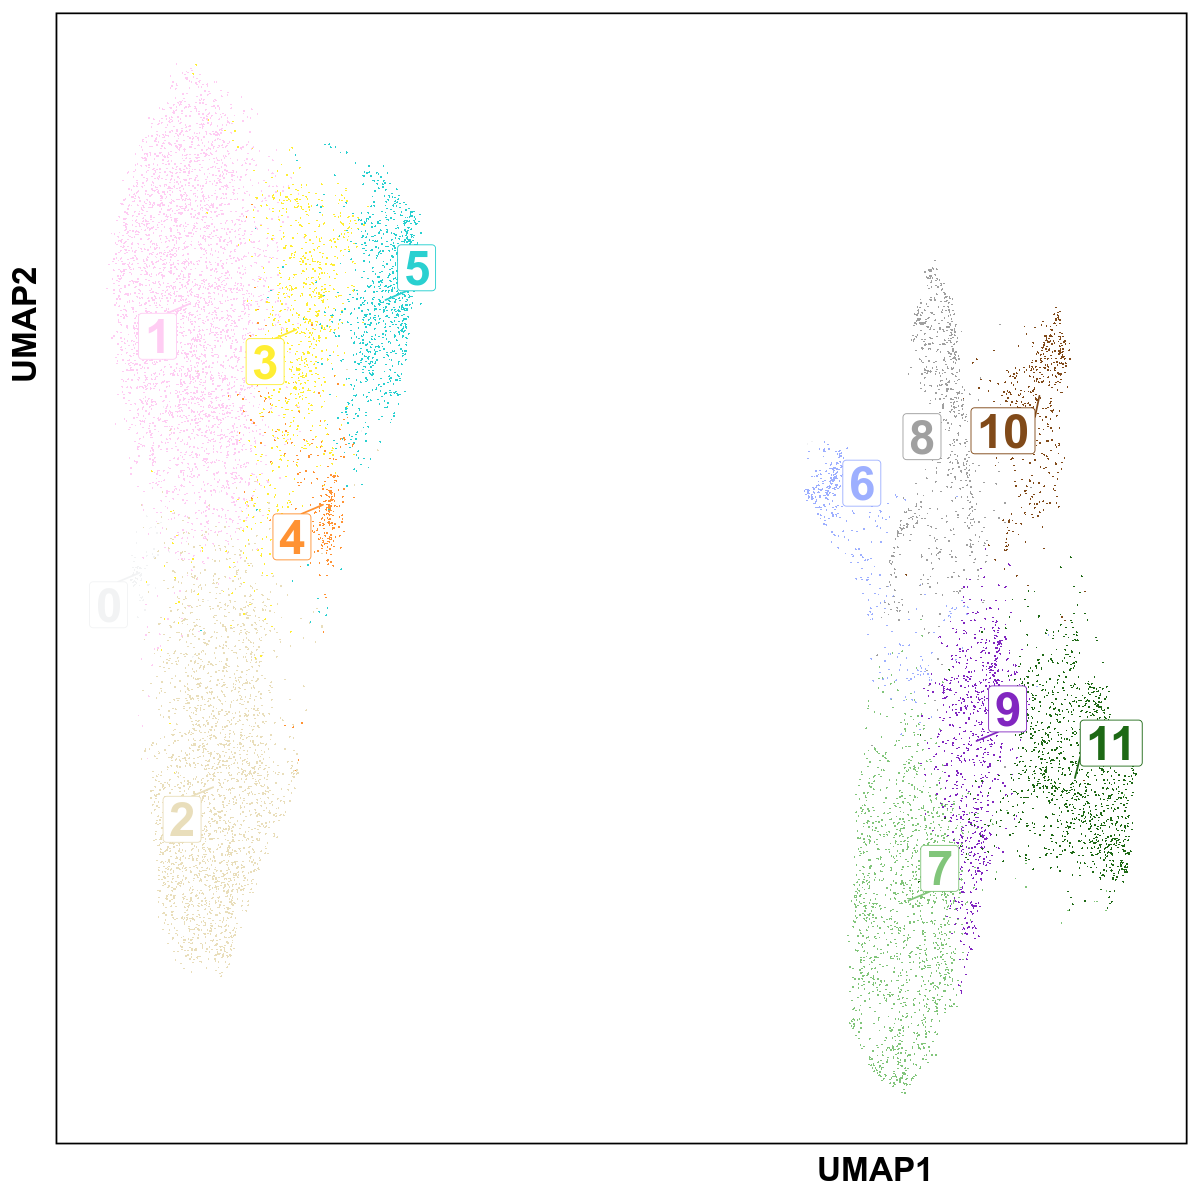

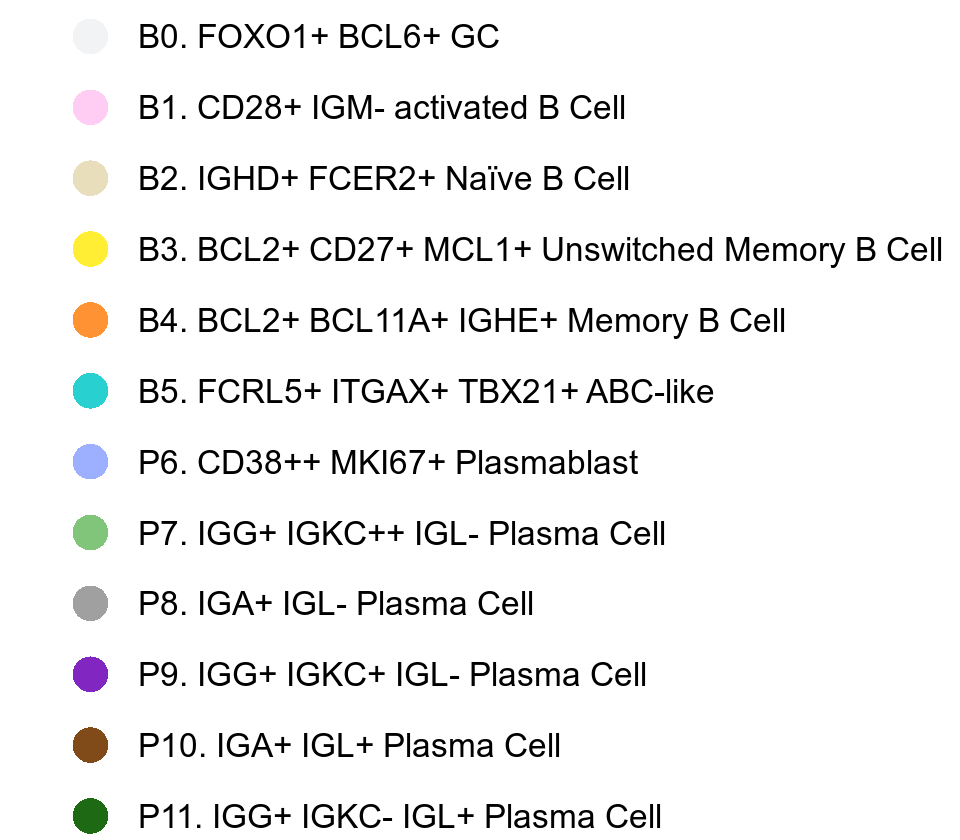

In [30]:
options(warn=-1)

cluster_center <- qcd_meta %>%
                  group_by(new_cluster_number, final_annotation) %>%
                  summarise_at(vars(hUMAP1, hUMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

p <- ggplot() +
      geom_point(
        data = qcd_meta[sample(nrow(qcd_meta)), ] %>% 
          select(hUMAP1, hUMAP2, new_cluster_number, final_annotation) %>% 
                  mutate(final_annotation = factor(final_annotation, 
                                                   levels = cluster_center$final_annotation)),
        aes(x = hUMAP1, y = hUMAP2, color = final_annotation),
          size = 0.75, shape = 20, stroke = 0.0001) +
      ggrepel::geom_label_repel(
        data = cluster_center,
        aes(x = hUMAP1, y = hUMAP2, 
            label = new_cluster_number, color = as.factor(final_annotation)),
        size = 10,  fontface = "bold",
        box.padding = unit(0.5, "lines"),
        point.padding = unit(0.01, "lines"),
        show.legend = FALSE
      ) +
    scale_color_manual(values = rev(as.vector(watlington(16)))) +
    theme_classic(base_size = 15) +
      theme(
        legend.position = "right",
            #  plot.title = element_text(hjust = 0.5, 
            #                            size = 18, 
            #                            face = "bold"),
              axis.title = element_text(hjust = 0.75, 
                                        size = 20, 
                                        face = "bold"), 
              axis.text = element_blank(),
              axis.line = element_blank(),
              axis.ticks = element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=1),
              legend.text = element_text(size = 20),
              legend.title = element_blank()
          
    ) +
    theme(text=element_text(family="Arial")) + 
        labs(x = "UMAP1", y = "UMAP2") +
        guides(color = guide_legend(ncol = 1, override.aes = list(size = 15)))
legend <- cowplot::get_legend(p)
p <- p + theme(legend.position = "none")
legend <- cowplot::plot_grid(legend)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/figure2/figure2b.png",
       p,
       base_height = 10,
       base_width = 10)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/figure2/figure2b-legend.png",
       legend,
       base_height = 7,
       base_width = 7)
fig.size(10, 10)
p
fig.size(7, 8)
legend
options(warn=0)

### Marker Gene UMAPs

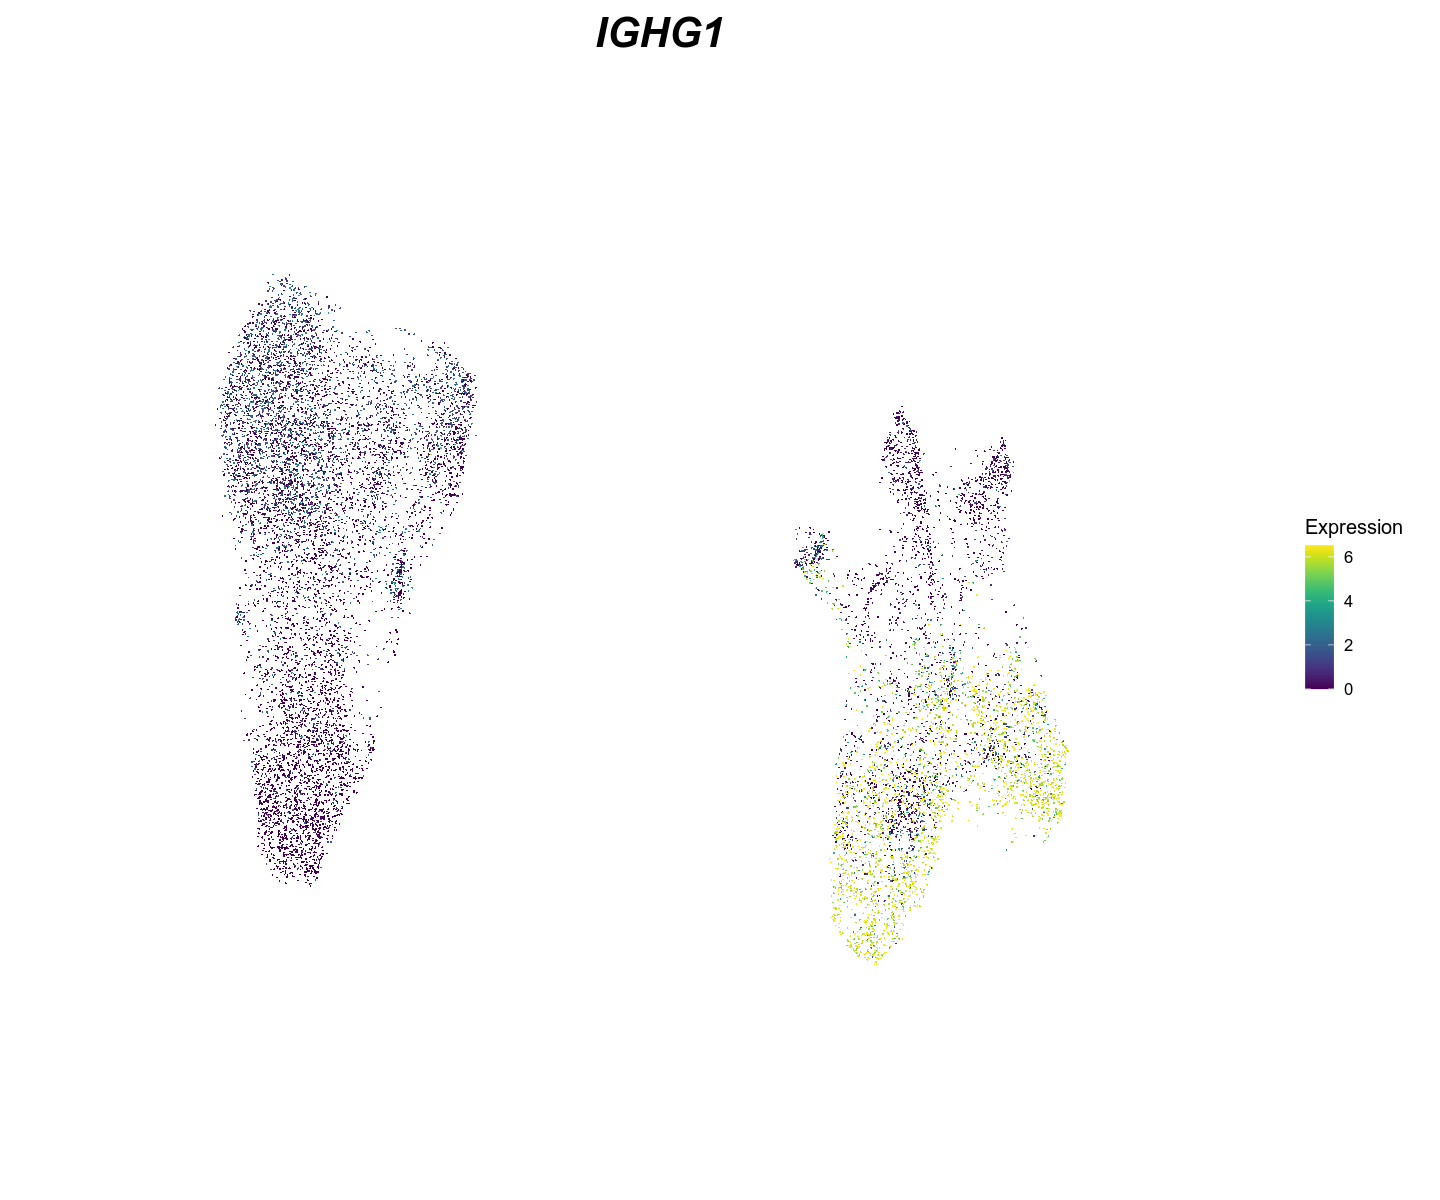

In [168]:
fig.size(10, 12)          
plot_shuffled_features(qcd_meta, qcd_norm, "IGHG1", 0.95, 0.75) +           
scale_x_continuous(limits = c(-10, 15)) +
scale_y_continuous(limits = c(-5, 5)) 

### sc vs sn heatmaps

In [52]:
qcd_meta <- left_join(qcd_meta, data.frame(new_cluster_number = seq(0, 11),
                                           final_annotation = c("B0. MME+ BCL6+ GC-like",
                                                                "B1. CD52+ TMSB4X+ IGM- B Cell",
                                                                "B2. IGHD+ FCER2+ Naïve B Cell",
                                                                "B3. CD24+ IGM+ Memory B Cell",
                                                                "B4. IGEhigh BCL11A+ B Cell",
                                                                "B5. ITGAX+ TBX21+ ABC", 
                                                                "P6. CD38++ MKI67+ Plasmablast",
                                                                "P7. IGG+ IGKC++ IGL- Plasma Cell",
                                                                "P8. IGA+ IGL- Plasma Cell",
                                                                "P9. IGG+ IGKC+ IGL- Plasma Cell",
                                                                "P10. IGA+ IGL+ Plasma Cell",
                                                                "P11. IGG+ IGKC- IGL+ Plasma Cell")))

Joining, by = "new_cluster_number"


In [59]:
final_annotation = c("B0. MME+ BCL6+ GC-like",
                                                                "B1. CD52+ TMSB4X+ IGM- B Cell",
                                                                "B2. IGHD+ FCER2+ Naïve B Cell",
                                                                "B3. CD24+ IGM+ Memory B Cell",
                                                                "B4. IGEhigh BCL11A+ B Cell",
                                                                "B5. ITGAX+ TBX21+ ABC", 
                                                                "P6. CD38++ MKI67+ Plasmablast",
                                                                "P7. IGG+ IGKC++ IGL- Plasma Cell",
                                                                "P8. IGA+ IGL- Plasma Cell",
                                                                "P9. IGG+ IGKC+ IGL- Plasma Cell",
                                                                "P10. IGA+ IGL+ Plasma Cell",
                                                                "P11. IGG+ IGKC- IGL+ Plasma Cell")

In [54]:
marker_genes <- c("MS4A1", "SDC1", "MME", "BCL6", "CD27", "CD52", "TMSB4X", "IGHM", "IGHD", "FCER2", 
                  "IGHE", "BCL11A", "CD38", "MKI67", "IGHA1", "IGHG1", "IGKC", "IGLC2")

In [55]:
wilcox_sn <- wilcoxauc(qcd_norm[, qcd_meta %>% filter(dataset == 'snRNAseq') %>% pull(cell)], 
                       qcd_meta %>% filter(dataset == 'snRNAseq') %>% pull(final_annotation))
wilcox_sc <- wilcoxauc(qcd_norm[, qcd_meta %>% filter(dataset == 'scRNAseq') %>% pull(cell)], 
                       qcd_meta %>% filter(dataset == 'scRNAseq') %>% pull(final_annotation))

In [56]:
sc_plot_df <- wilcox_sc %>%  filter(feature %in% marker_genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 
sn_plot_df <- wilcox_sn %>%  filter(feature %in% marker_genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 

In [57]:
range(sc_plot_df$avgExpr_scaled)

[1] -1.548317  3.084259

In [ ]:
marker_genes <- c("MS4A1", , "MME", "BCL6", "CD27", "CD52", "TMSB4X", "IGHM", "IGHD", "FCER2", 
                  "IGHE", "BCL11A", "CD38", "MKI67", "IGHA1", "IGHG1",  "IGLC2", "SDC1")

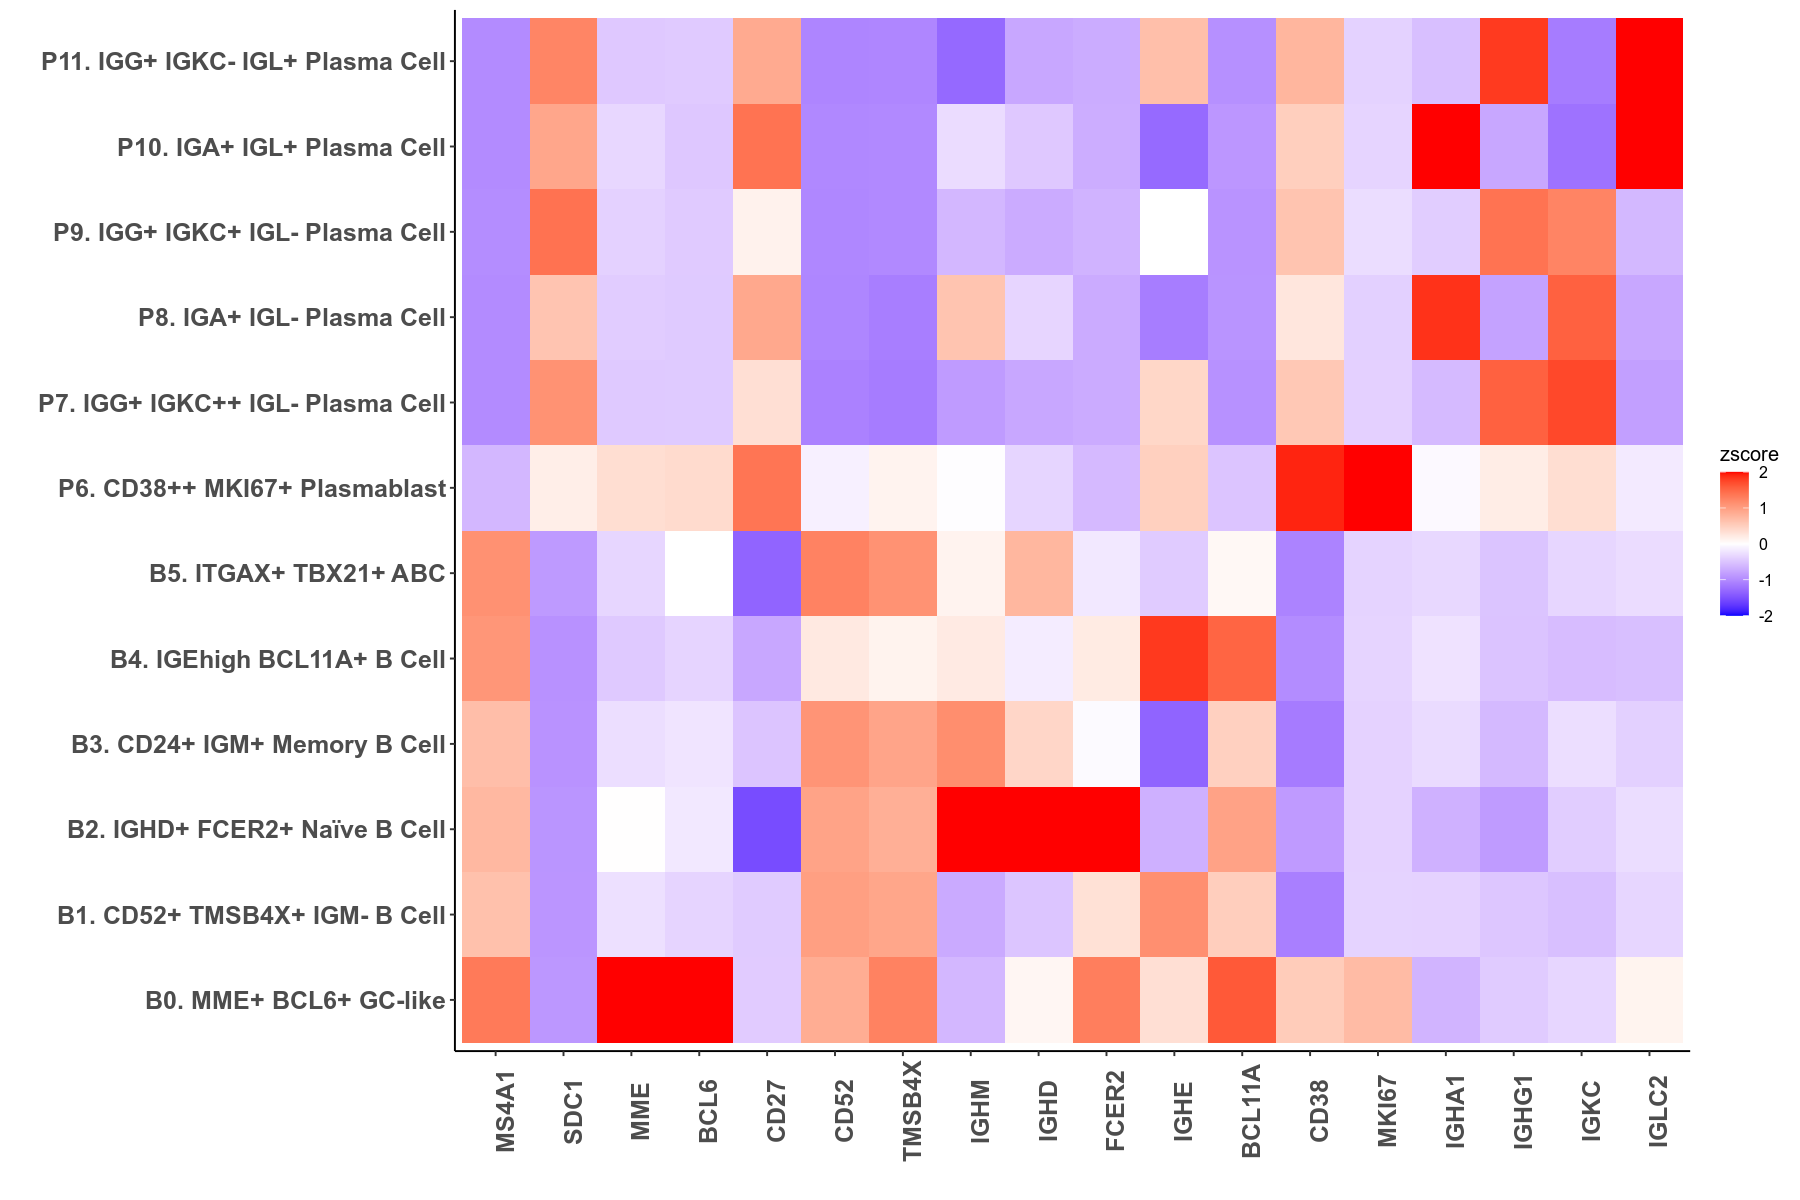

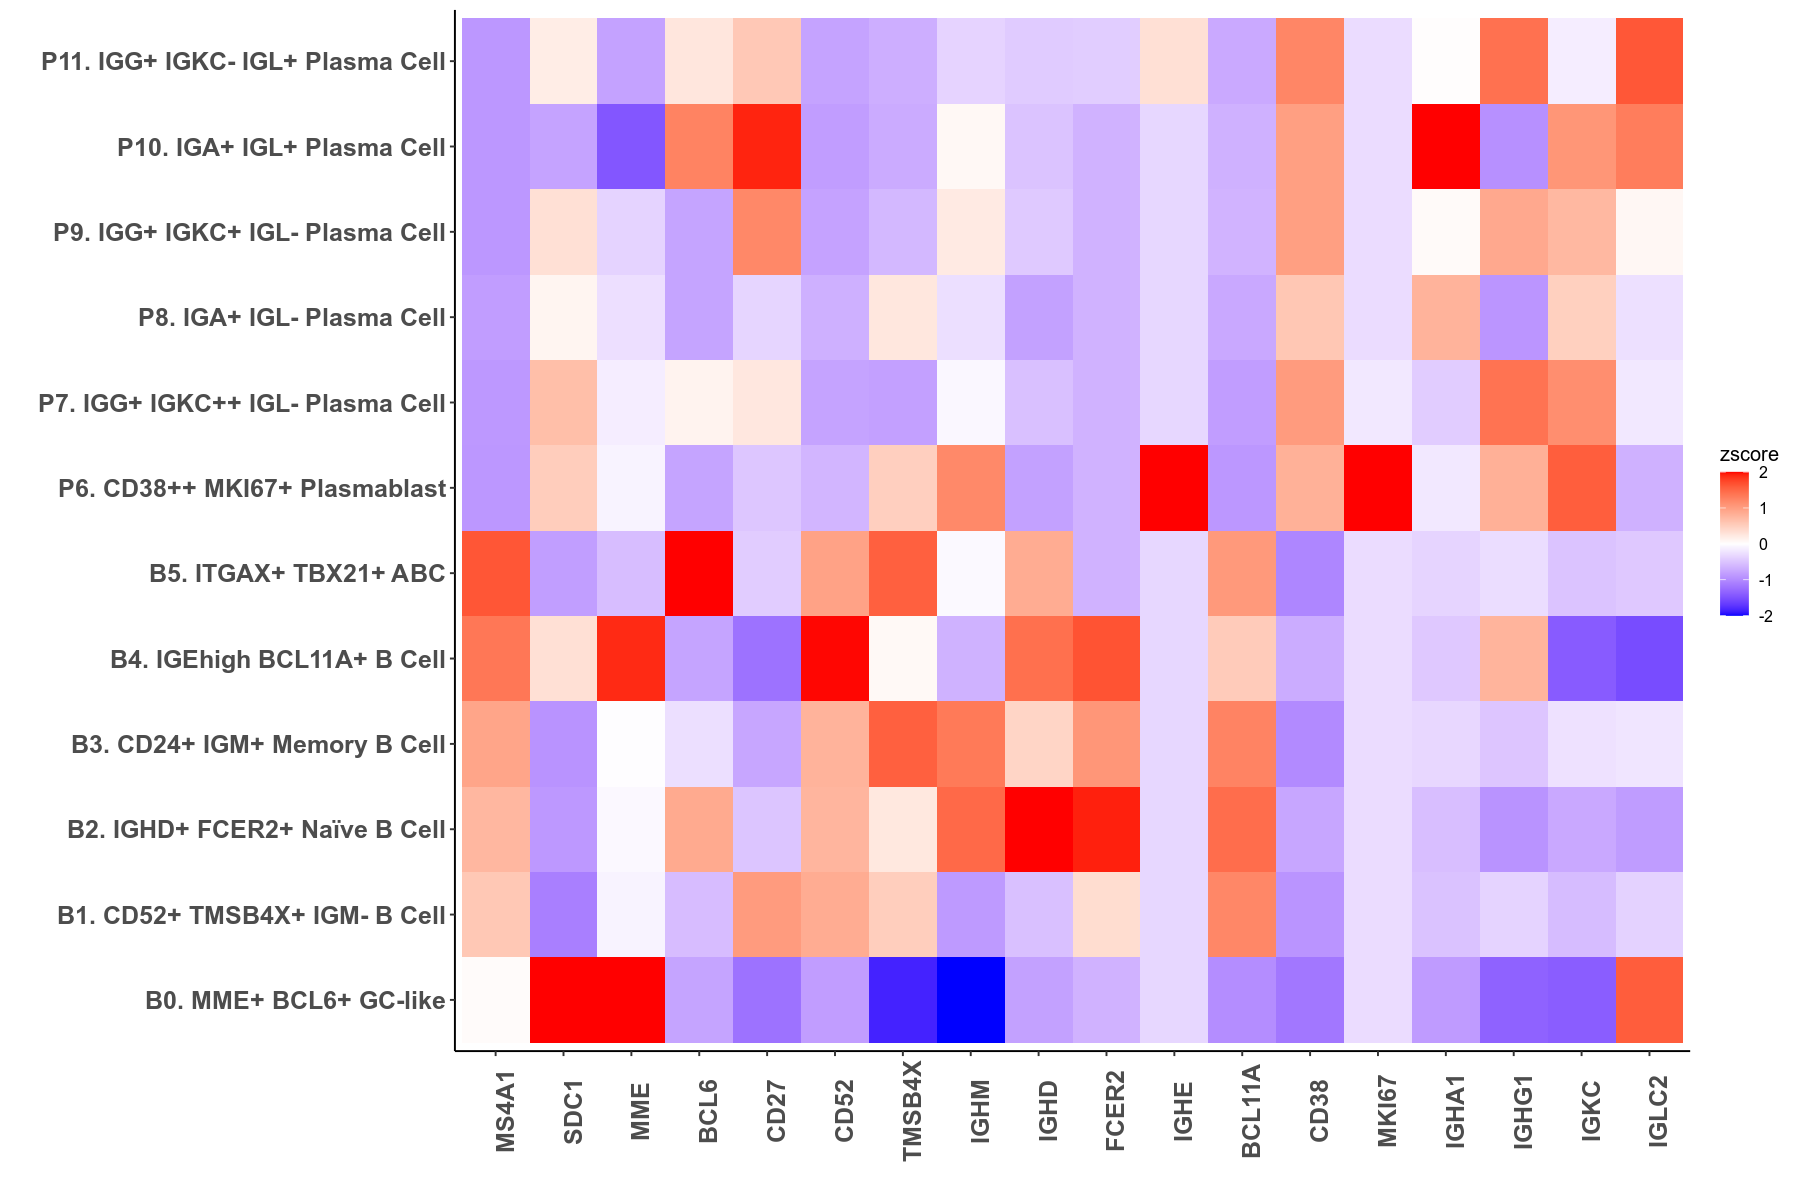

In [61]:
fig.size(10, 15)
ggplot(sc_plot_df %>% rename(percent = pct_in,
                             zscore = avgExpr_scaled), 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-2, 2), 
                         oob = scales::squish) + 
    scale_x_discrete(limits = marker_genes) + 
    scale_y_discrete(limits = final_annotation) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(face = "bold", size = 15),
          axis.title = element_text(size = 15)) + 
    labs(x = "", y = "")
ggplot(sn_plot_df %>% rename(percent = pct_in,
                             zscore = avgExpr_scaled), 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-2, 2), 
                         oob = scales::squish) + 
    scale_x_discrete(limits = marker_genes) + 
    scale_y_discrete(limits = final_annotation) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(face = "bold", size = 15),
          axis.title = element_text(size = 15)) + 
    labs(x = "", y = "")

### Cluster Proportions in Matched Patients

In [62]:
qcd_meta <- qcd_meta  %>% 
                mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% 
                mutate(individual = unlist(individual)[3]) 

In [63]:
sample_freq <- qcd_meta %>% select(dataset, individual, new_cluster_number) %>% 
                    table() %>% data.frame() %>% 
                    pivot_wider(names_from = "new_cluster_number", values_from = Freq) 

In [64]:
ind_list <- qcd_meta %>% select(dataset, individual) %>% 
                table() %>% data.frame() %>% 
                pivot_wider(names_from = 'dataset', values_from = "Freq") %>% filter(scRNAseq > 15 & snRNAseq > 15) %>% 
                pull(individual)

In [65]:
sample_freq_sc <- sample_freq %>% 
                    filter(individual %in% ind_list) %>% 
                    select(- individual) %>% 
                    filter(dataset == "scRNAseq") %>% 
                    select(-dataset) %>% colSums()

sample_freq_sn <- sample_freq %>% 
                    filter(individual %in% ind_list) %>% 
                    select(- individual) %>% 
                    filter(dataset == "snRNAseq") %>% 
                    select(-dataset) %>% colSums()

In [66]:
sample_freq <- data.frame(rep("a", 12))
sample_freq$sc_freq <- sample_freq_sc / sum(sample_freq_sc)
sample_freq$sc_se <- sqrt((sample_freq$sc_freq * (1 - sample_freq$sc_freq)) / sample_freq_sc)
sample_freq$sn_freq <- sample_freq_sn / sum(sample_freq_sn)
sample_freq$sn_se <- sqrt((sample_freq$sn_freq * (1 - sample_freq$sn_freq)) / sample_freq_sn)
sample_freq <- sample_freq[,- 1]
sample_freq$new_cluster_number <- as.character(seq(0, 11))

In [73]:
sample_freq

sc_freq,sc_se,sn_freq,sn_se,new_cluster_number
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.02022654,0.01990850,0.004761905,0.03974598,0
0.31391586,0.01665960,0.157142857,0.03657688,1
0.16545307,0.01837389,0.084126984,0.03812829,2
0.06027508,0.01949737,0.060317460,0.03862071,3
0.02346278,0.01987560,0.012698413,0.03958719,4
0.05137540,0.01958948,0.055555556,0.03871845,5
0.04004854,0.01970609,0.017460317,0.03949160,6
0.12580906,0.01880524,0.287301587,0.03363432,7
0.04652104,0.01963954,0.055555556,0.03871845,8


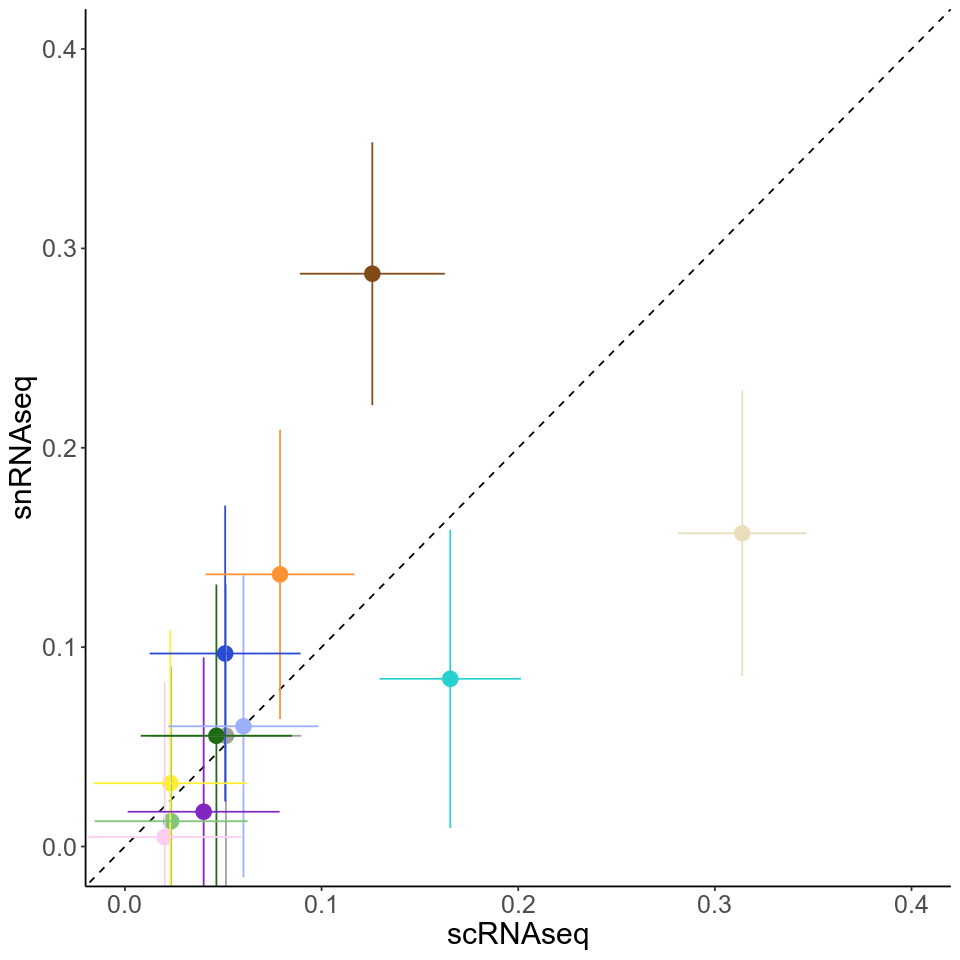

In [100]:
fig.size(8, 8)

max_val <- max(sample_freq[, c("sc_freq", "sn_freq")])

ggplot(sample_freq, aes(x = sc_freq, y = sn_freq, color = new_cluster_number)) + 
    geom_abline(linetype = "dashed") +
    scale_color_manual(values =as.vector(rev(watlington(15)))) +
    theme_classic() + 
    geom_point(size = 4) + 
    geom_linerange(aes(ymax = sn_freq+1.96*sn_se, 
                        ymin = sn_freq-1.96*sn_se)) +
    geom_linerange(aes(xmax = sc_freq+1.96*sc_se, 
                        xmin = sc_freq-1.96*sc_se)) +
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18)) +
    coord_cartesian(xlim = c(0, 0.4), ylim = c(0, 0.4)) + 
    ggpubr::stat_cor(label.x = 0.25, label.y = 0.1, size = 5) + 
    labs(x = "scRNAseq",
         y = "snRNAseq")

In [101]:
cor.test(sample_freq$sc_freq, sample_freq$sn_freq)


	Pearson's product-moment correlation

data:  sample_freq$sc_freq and sample_freq$sn_freq
t = 2.213, df = 10, p-value = 0.0513
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.0008135199  0.8632162556
sample estimates:
      cor 
0.5733558 


### sc/sn qq ratio

In [10]:
#find individual from sample
qcd_meta <- qcd_meta %>% 
                        mutate(individual = str_split(sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3])
#filter for individuals with > X cells 
ind_meta <- qcd_meta %>% 
                    select(individual, dataset) %>% 
                    table() %>% data.frame() 

ind_keep <- vector() 

for (i in unique(ind_meta$individual)) {
    ind_subset <- ind_meta %>% filter(individual == i)
        if (all(ind_subset$Freq > 10)) {
            ind_keep <- c(ind_keep, i)
        }
}

#pseudobulking
qq_pb_sc <- data.frame(nrow = nrow(qcd_norm))
individuals_sc <- vector()

for (i in ind_keep) {
            subset <- qcd_meta %>% filter(individual == i, 
                                                 dataset == "scRNAseq") %>% 
                        pull(cell)
            pb_vec <- rowMeans(qcd_norm[, subset])
            qq_pb_sc <- cbind(qq_pb_sc, pb_vec)
            individuals_sc <- c(individuals_sc, i)
}

qq_pb_sn <- data.frame(nrow = nrow(qcd_norm))
individuals_sn <- vector()

for (i in ind_keep) {
    subset <- qcd_meta %>% filter(individual == i, 
                                                 dataset == "snRNAseq") %>% 
                        pull(cell)
            pb_vec <- rowMeans(qcd_norm[, subset])
            qq_pb_sn <- cbind(qq_pb_sn, pb_vec)
            individuals_sn <- c(individuals_sn, i)
}

#remove extraneous first column
qq_pb_sc <- qq_pb_sc[, -1]
qq_pb_sn <- qq_pb_sn[, -1]

#assign column names
colnames(qq_pb_sc) <- paste0(individuals_sc, "_sc")
colnames(qq_pb_sn) <- paste0(individuals_sn, "_sn")
qq_pb <- cbind(qq_pb_sc, qq_pb_sn)

#qqnormalization 
index_to_mean <- function(my_index, my_mean){
  return(my_mean[my_index])
}
df_rank <- apply(qq_pb,2,rank,ties.method="first")
df_sort <- data.frame(apply(qq_pb, 2, sort))
df_mean <- apply(df_sort, 1, mean)
df_final <- apply(df_rank, 2, index_to_mean, my_mean=df_mean)

#transpose to df
df_final <- t(df_final) %>% data.frame()

#assign covariates from rownames
df_final <- df_final %>% mutate(ind = sapply(rownames(df_final), 
                                             FUN = function(x) unlist(str_split(x, "_"))[1]),
                                technology = sapply(rownames(df_final), 
                                                    FUN = function(x) unlist(str_split(x, "_"))[2]))

#run pb linear model
out_bp <- data.frame()
for (i in 1:nrow(qcd_norm)) {
    gene = rownames(qcd_norm)[i]
    model_df <- cbind(df_final[, i], df_final %>% select(ind, technology))
    colnames(model_df) <- c('Exp', 'ind', 'technology')
    H0 <- lm(Exp ~ ind, data = model_df)
    H1 <- lm(Exp ~ ind + technology, data = model_df)

    ANNO <- anova(H0, H1)
    LRP <- ANNO[2,6]
    F <- ANNO[2,5]
    Beta <- summary(H1)$coefficients['technologysn', 'Estimate']
    SE <- summary(H1)$coefficients['technologysn', 'Std. Error']
    res <- c(gene = gene, LRP = LRP, F = F, Beta = Beta, SE = SE)
    out_bp <- rbind(out_bp, res)
}

#format output 
colnames(out_bp) <- c('gene', 'LRP', 'F', 'Beta', 'SE')
out_bp[out_bp == "NaN"] <- NA

In [13]:
out_filter <- out_bp %>% na.omit() %>% 
                mutate(LRP = as.numeric(LRP),
                       F = as.numeric(F),
                       Beta = as.numeric(Beta),
                       SE = as.numeric(SE)) %>% 
                mutate(FDR = p.adjust(LRP, method = "BH")) %>% 
                filter(FDR < 0.05)

In [14]:
library(msigdbr)
library(fgsea)

##format for gsea 
FC.vec <- out_filter$Beta
names(FC.vec) <- out_filter$gene

scoreType <- "std"

H <- msigdbr(species = "Homo sapiens", category = "H")

H.ensembl.ls <- H %>% 
  select(gs_name, gene_symbol) %>% 
  group_by(gs_name) %>% 
  summarise(all.genes = list(unique(gene_symbol))) %>% 
  tibble::deframe()

#Run GSEA
gsea.H <- fgseaSimple(pathways = H.ensembl.ls,
                      stats = FC.vec,
                      scoreType = scoreType,
                      nperm=10000)

Warning message:
“Removed 7811 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 274 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


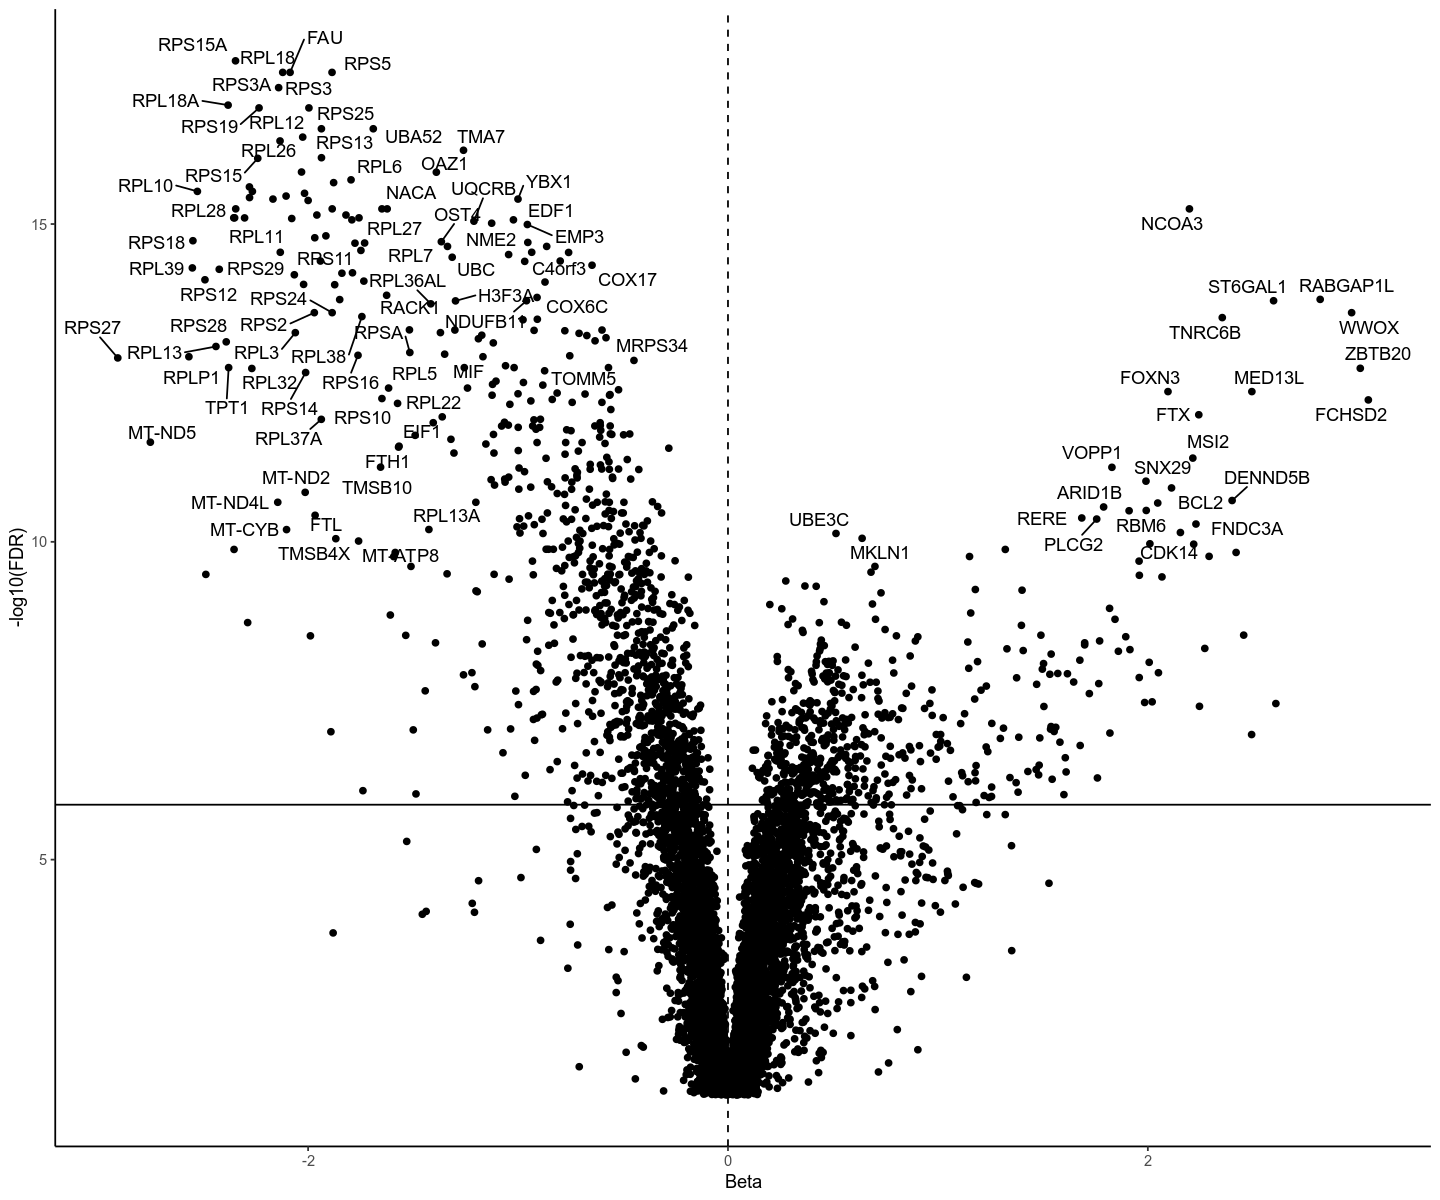

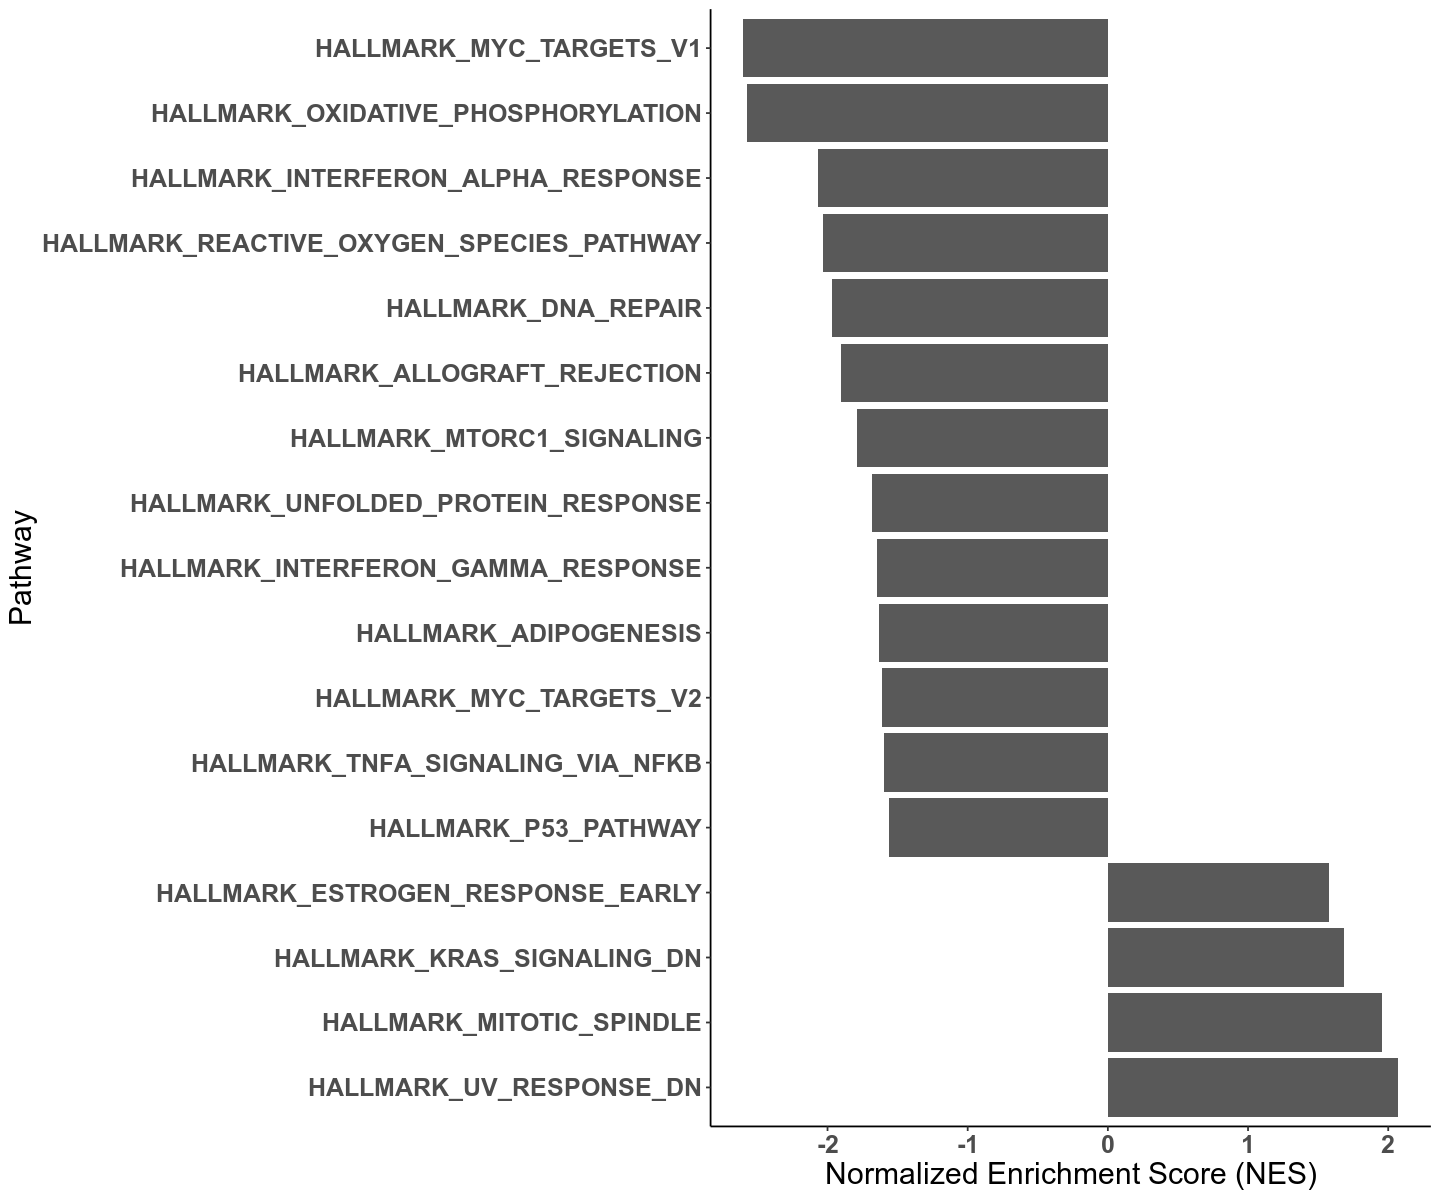

In [16]:
fig.size(10,12)

ggplot(out_filter %>% 
           mutate(label = ifelse(-log10(FDR) > 10, gene, NA)), aes(x = Beta, y = -log10(FDR))) + 
    geom_point() + 
    geom_vline(aes(xintercept = 0), linetype = "dashed") + 
    geom_hline(aes(yintercept = -log10(0.05/36601))) + 
    theme_classic() + 
    ggrepel::geom_text_repel(aes(label = label))


ggplot(gsea.H %>% filter(padj < 0.05), aes(x = NES, y = pathway)) +
    geom_bar(stat = "identity") +
    theme_classic() + 
    scale_y_discrete(limits = gsea.H %>% filter(padj < 0.05) %>% arrange(desc(NES)) %>% pull(pathway)) + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15, face = "bold"),
          axis.title = element_text(size = 18)) +
    labs(x = 'Normalized Enrichment Score (NES)', y = 'Pathway')

### GSEA

In [ ]:
ind_list <- qcd_meta %>% mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% filter(Type == "LN") %>% 
                mutate(individual = unlist(individual)[3])  %>%
                select(dataset, individual) %>%
                table() %>% data.frame() %>% pivot_wider(names_from = "dataset", values_from = "Freq") %>% 
                filter(scRNAseq > 0 & snRNAseq > 0) %>% pull(individual)

ind_meta <- qcd_meta %>% mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% filter(Type == "LN") %>% 
                mutate(individual = unlist(individual)[3]) %>% 
                filter(individual %in% ind_list)

ind_norm <- qcd_norm[, ind_meta$cell]

In [ ]:
wilcox <- wilcoxauc(ind_norm, ind_meta$dataset)

In [ ]:
wilcox <- wilcox %>% filter(group == "scRNAseq")

In [ ]:
library(msigdbr)
library(fgsea)

##format for gsea 
FC.vec <- wilcox$logFC
names(FC.vec) <- wilcox$feature

scoreType <- "std"

H <- msigdbr(species = "Homo sapiens", category = "H")

H.ensembl.ls <- H %>% 
  select(gs_name, gene_symbol) %>% 
  group_by(gs_name) %>% 
  summarise(all.genes = list(unique(gene_symbol))) %>% 
  tibble::deframe()

#Run GSEA
gsea.H <- fgseaSimple(pathways = H.ensembl.ls,
                      stats = FC.vec,
                      scoreType = scoreType,
                      nperm=10000)

In [ ]:
fig.size(10,12)
ggplot(gsea.H %>% filter(padj < 0.05), aes(x = NES, y = pathway)) +
    geom_bar(stat = "identity") +
    scale_y_discrete(limits = gsea.H %>% filter(padj < 0.05) %>% arrange(desc(NES)) %>% pull(pathway)) + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15, face = "bold"),
          axis.title = element_text(size = 18)) +
    labs(x = 'Normalized Enrichment Score (NES)', y = 'Pathway')

## Case/Control

In [38]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/BP_clusterQCd_cellstate_meta_annotations_09232022.rds')
qcd_meta <- qcd_meta %>% left_join(percent_mito)
final_annotation <- data.frame(new_cluster_number = seq(0, 11),
                                           final_annotation = c("B0. FOXO1+ BCL6+ GC",
                                                                "B1. CD28+ IGM- activated B Cell",
                                                                "B2. IGHD+ FCER2+ Naïve B Cell",
                                                                "B3. BCL2+ CD27+ MCL1+ Unswitched Memory B Cell",
                                                                "B4. BCL2+ BCL11A+ IGHE+ Memory B Cell",
                                                                "B5. FCRL5+ ITGAX+ TBX21+ ABC-like", 
                                                                "P6. CD38++ MKI67+ Plasmablast",
                                                                "P7. IGG+ IGKC++ IGL- Plasma Cell",
                                                                "P8. IGA+ IGL- Plasma Cell",
                                                                "P9. IGG+ IGKC+ IGL- Plasma Cell",
                                                                "P10. IGA+ IGL+ Plasma Cell",
                                                                "P11. IGG+ IGKC- IGL+ Plasma Cell"))

qcd_meta <- qcd_meta %>% left_join(final_annotation)

Joining, by = "cell"
Joining, by = "new_cluster_number"


In [41]:
saveRDS(qcd_meta %>% select(-c(Annot.separate, annotation, arnon_cluster, qc_cluster)),
        '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/b_plasma_meta_qcd_harmony_umap_clusternames_12152023.rds')

### CNA

Joining, by = "new_cluster_number"


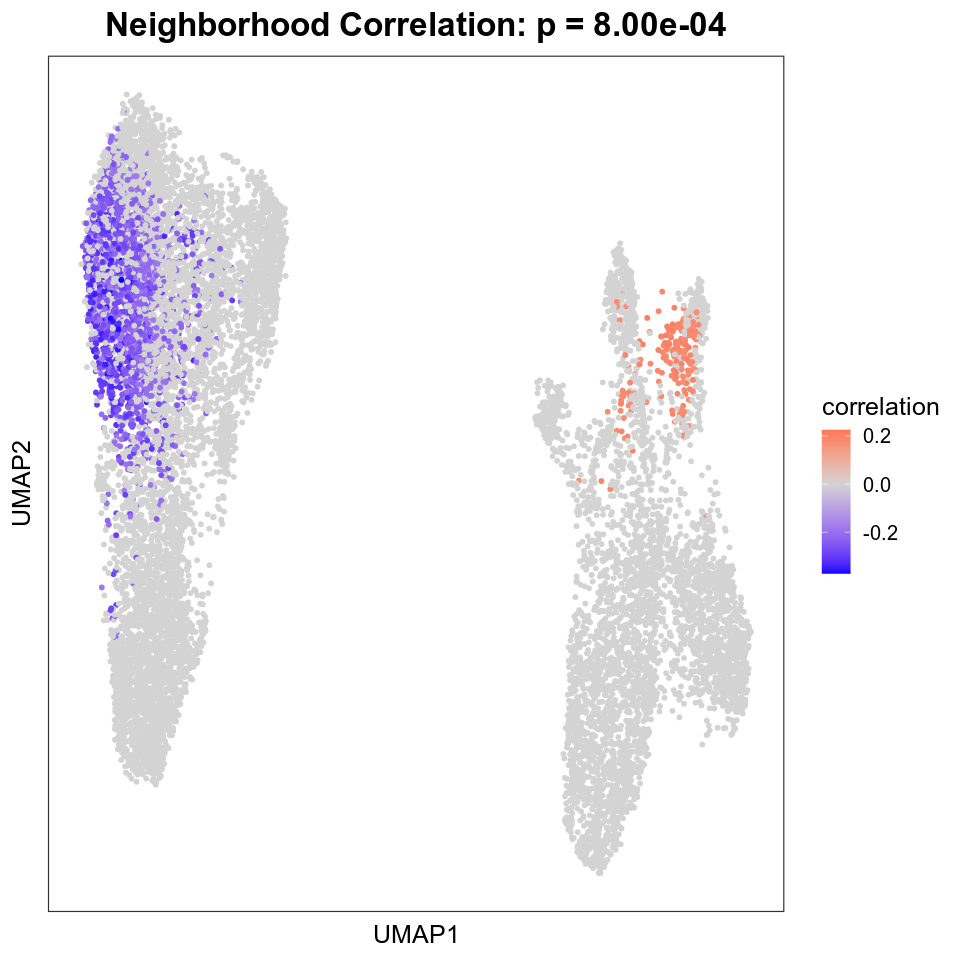

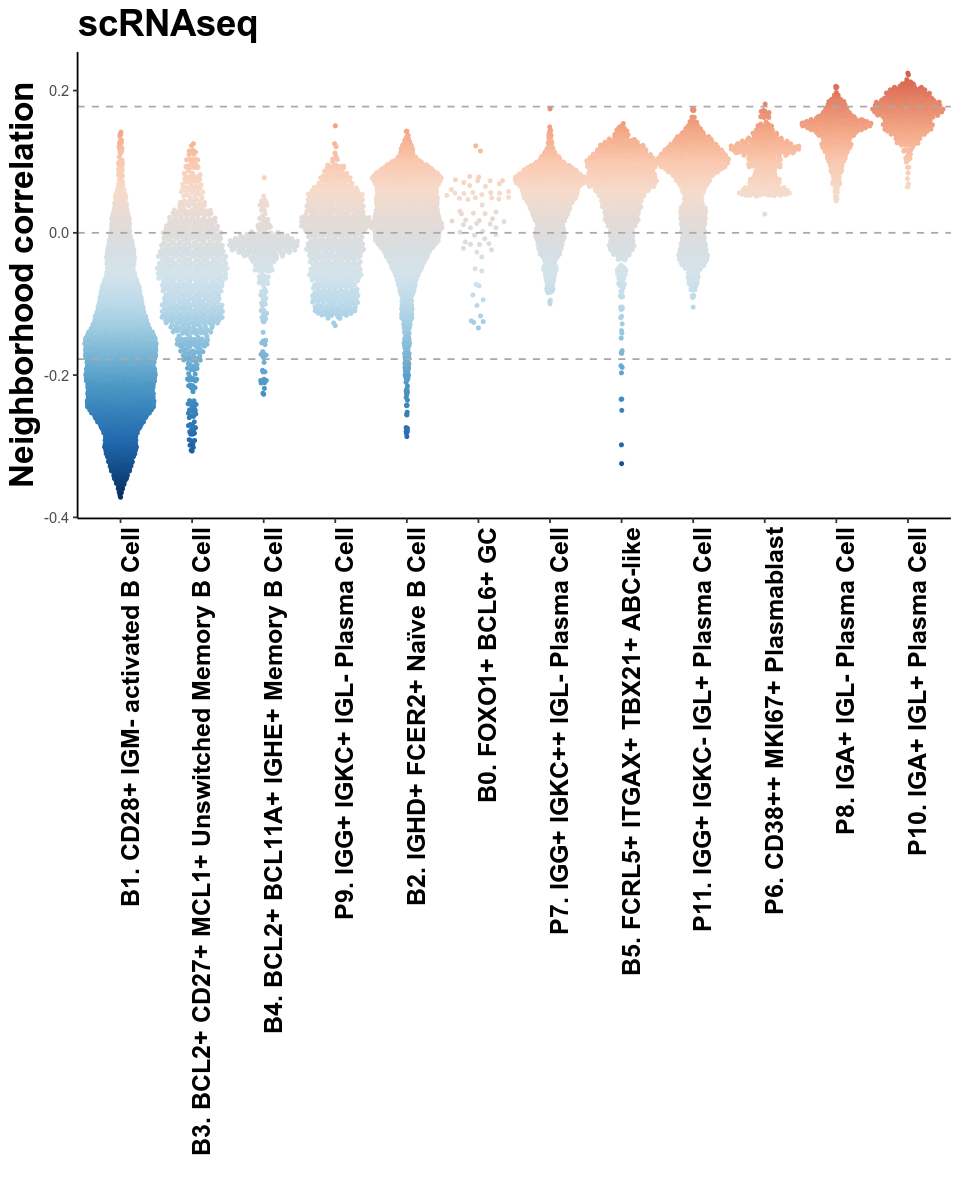

In [4]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/BP_clusterQCd_cellstate_meta_annotations_09232022.rds')

meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/b_plasma/sc_b_plasma_casecontrol_meta.csv')
kept <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/b_plasma/sc_b_plasma_casecontrol.kept.csv')
kept <- kept[, 1]
kept <- which(kept == TRUE)
thresh <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/b_plasma/sc_b_plasma_casecontrol.thresh.csv', header = FALSE)
ncorr <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/b_plasma/sc_b_plasma_casecontrol.ncorrs.csv', header = FALSE)
ncorr <- ncorr[, 1]

meta_tmp_1 <- meta
meta_tmp_1$ncorr <- as.numeric(ncorr)

thresh10 <- thresh[2, ]


meta_tmp_1$ncorr <- as.numeric(ncorr)


umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/b_plasma/sc_b_plasma_casecontrol_umap.csv')


meta_tmp_1$UMAP1 <- umap$hUMAP1
meta_tmp_1$UMAP2 <- umap$hUMAP2


meta_tmp_1$ncorr[which(abs(meta_tmp_1$ncorr) < thresh10)] <- NA


fig.size(8, 8)
ggplot(
      data = meta_tmp_1[sample(nrow(meta_tmp_1)),] %>% rename(correlation = ncorr), 
      aes(x = UMAP1, y = UMAP2)) + 
      geom_point(mapping = aes(color = correlation), alpha = 5, size = 1) + 
#      geom_point(data = qcd_meta %>% filter(dataset == 'snRNAseq'), aes(x = hUMAP1, y = hUMAP2), color = 'black', alpha = 0.1) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "Neighborhood Correlation: p = 8.00e-04") +
      theme_bw(base_size = 15) +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 
pos_fdr_thres <- thresh10
neg_fdr_thresh <- -1 * thresh10


meta$ncorr <- as.numeric(ncorr)

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)

meta <- left_join(meta, data.frame(new_cluster_number = seq(0, 11),
                                           final_annotation = c("B0. FOXO1+ BCL6+ GC",
                                                                "B1. CD28+ IGM- activated B Cell",
                                                                "B2. IGHD+ FCER2+ Naïve B Cell",
                                                                "B3. BCL2+ CD27+ MCL1+ Unswitched Memory B Cell",
                                                                "B4. BCL2+ BCL11A+ IGHE+ Memory B Cell",
                                                                "B5. FCRL5+ ITGAX+ TBX21+ ABC-like", 
                                                                "P6. CD38++ MKI67+ Plasmablast",
                                                                "P7. IGG+ IGKC++ IGL- Plasma Cell",
                                                                "P8. IGA+ IGL- Plasma Cell",
                                                                "P9. IGG+ IGKC+ IGL- Plasma Cell",
                                                                "P10. IGA+ IGL+ Plasma Cell",
                                                                "P11. IGG+ IGKC- IGL+ Plasma Cell")))

ggplot(meta, 
       aes(x = reorder(final_annotation, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = thresh10, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = -1 * thresh10, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
   labs(title = "scRNAseq", x= "", y = "Neighborhood correlation") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold"),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

### DE

In [ ]:
wilcox <- wilcoxauc(qcd_norm, 
                    qcd_meta$Type) %>% filter(group == "LN")

In [ ]:
ggplot(wilcox  %>% mutate(label = ifelse(-log10(padj) > 10, feature, NA)), aes(x = logFC, y = -log10(padj))) +
    geom_point() + 
    geom_hline(yintercept = -log10(0.05 / nrow(wilcox)), linetype = "dashed", color = "red") +
    geom_vline(xintercept = 0, linetype = "dashed") + 
    scale_y_continuous(limits = c(0, max(-log10(wilcox$padj)))) + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18)) +
    ggrepel::geom_text_repel(aes(label = label)) +
    labs(x = "log2 Fold Change", y = "-log10 adjusted p-value")

In [ ]:
library(msigdbr)
library(fgsea)

##format for gsea 
FC.vec <- wilcox$logFC
names(FC.vec) <- wilcox$feature

scoreType <- "std"

H <- msigdbr(species = "Homo sapiens", category = "H")

H.ensembl.ls <- H %>% 
  select(gs_name, gene_symbol) %>% 
  group_by(gs_name) %>% 
  summarise(all.genes = list(unique(gene_symbol))) %>% 
  tibble::deframe()

#Run GSEA
gsea.H <- fgseaSimple(pathways = H.ensembl.ls,
                      stats = FC.vec,
                      scoreType = scoreType,
                      nperm=10000)

In [ ]:
gsea.H %>% filter(padj < 0.1)

## WITHIN CASE ASSOCIATIONS

In [454]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/BP_clusterQCd_cellstate_meta_annotations_09232022.rds')

final_annotation = data.frame(final_annotation = c("B0. MME+ BCL6+ GC-like",
                                                                "B1. CD27+ IGM- B Cell",
                                                                "B2. IGHD+ FCER2+ Naïve-like B Cell",
                                                                "B3. CD24+ IGM+ Memory-like B Cell",
                                                                "B4. IGEhigh BCL11A+ B Cell",
                                                                "B5. ITGAX+ TBX21+ ABC-like", 
                                                                "P6. CD38++ MKI67+ Plasmablast",
                                                                "P7. IGG+ IGKC++ IGL- Plasma Cell",
                                                                "P8. IGA+ IGL- Plasma Cell",
                                                                "P9. IGG+ IGKC+ IGL- Plasma Cell",
                                                                "P10. IGA+ IGL+ Plasma Cell",
                                                                "P11. IGG+ IGKC- IGL+ Plasma Cell"),
                              new_cluster_number = seq(0 ,11))
qcd_meta <- qcd_meta %>% left_join(final_annotation)

Joining, by = "new_cluster_number"


In [455]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

In [456]:
sc_meta <- qcd_meta[, !colnames(qcd_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = qcd_meta$sample) %>% 
                        filter(dataset == 'scRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        filter(Type == "LN") %>% 
                        select(c(cell, paste0('hPC', 1:20), Sex, hUMAP1, hUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

sn_meta <- qcd_meta[, !colnames(qcd_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = qcd_meta$sample) %>% 
                        filter(dataset == 'snRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        filter(Type == "LN") %>% 
                        select(c(cell, paste0('hPC', 1:20), Sex, hUMAP1, hUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

Joining, by = "individual"
Joining, by = "individual"
Joining, by = "individual"
Joining, by = "individual"


### AGE

In [334]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Age)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sn_meta_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sn_harmony_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sn_umap_age.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [335]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Age)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sc_meta_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sc_harmony_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sc_umap_age.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### SEX

In [336]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[which(meta$Sex %in% c("Female", "Male"))]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sn_meta_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sn_harmony_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sn_umap_sex.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [337]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[which(meta$Sex %in% c("Female", "Male"))]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sc_meta_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sc_harmony_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sc_umap_sex.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### RESPONSE

In [338]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sn_meta_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sn_harmony_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sn_umap_response.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [339]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sc_meta_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sc_harmony_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sc_umap_response.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### RACE

In [340]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Race)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sn_meta_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sn_harmony_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sn_umap_race.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [341]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Race)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sc_meta_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sc_harmony_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/age_sex_response_race/sc_umap_race.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### FIRST BIOPSY

In [398]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$First_biop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sn_meta_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sn_harmony_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sn_umap_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [399]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$First_biop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sc_meta_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sc_harmony_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sc_umap_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### PRED USE

In [400]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Pred_use)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sn_meta_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sn_harmony_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sn_umap_preduse.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [401]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Pred_use)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sc_meta_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sc_harmony_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sc_umap_preduse.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### SITE

In [402]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Site)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sn_meta_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sn_harmony_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sn_umap_site.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [403]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Site)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sc_meta_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sc_harmony_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/first_biop_pred_use_site/sc_umap_site.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### Chronicity

In [349]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- which(is.na(meta$Final_Chronicity))
meta <- meta[-ind, ]
harmony <- harmony[-ind, ]
umap <- umap[-ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/chronicity/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/chronicity/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/chronicity/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [350]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- which(is.na(meta$Final_Chronicity))
meta <- meta[-ind, ]
harmony <- harmony[-ind, ]
umap <- umap[-ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/chronicity/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/chronicity/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/chronicity/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


#### MASC

In [457]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/chronicity/sc_meta.csv')

model_df <- meta %>% 
                left_join(qcd_meta %>% select(cell,  new_cluster_number)) 

res <- MASC.me(model_df, as.factor(model_df$new_cluster_number),
                contrast = "Final_Chronicity",
                random_effects = c("sample"),
                fixed_effects = c('First_biop', 'Responder_Status'),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)

Joining, by = "cell"
Using null model: cluster ~ First_biop + Responder_Status + (1|sample)

Creating logistic mixed models for cluster0

Creating logistic mixed models for cluster1

Creating logistic mixed models for cluster10

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0874882 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”
Creating logistic mixed models for cluster11

Creating logistic mixed models for cluster2

Creating logistic mixed models for cluster3

Creating logistic mixed models for cluster4

Creating logistic mixed models for cluster5

Creating logistic mixed models for cluster6

Creating logistic mixed models for cluster7

Creating logistic mixed models for cluster8

Creating logistic mixed models for cluster9



In [458]:
res

,cluster,size,model.pvalue,Final_Chronicity.OR,Final_Chronicity.OR.95pct.ci.lower,Final_Chronicity.OR.95pct.ci.upper,bonferroni
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cluster3,cluster3,757,0.1861629,0.9566461,0.8971415,1.0200975,1
cluster1,cluster1,3390,0.3150518,1.0493153,0.9553137,1.1525666,1
cluster9,cluster9,692,0.3549709,0.9505142,0.8546923,1.0570790,1
cluster0,cluster0,67,0.4932729,1.1155883,0.8162311,1.5247363,1
cluster2,cluster2,2205,0.5234002,1.0398679,0.9228702,1.1716980,1
cluster5,cluster5,761,0.6571226,0.9791088,0.8934607,1.0729672,1
cluster6,cluster6,344,0.7944154,0.9786290,0.8319435,1.1511775,1
cluster8,cluster8,618,0.8152223,0.9854634,0.8717042,1.1140683,1
cluster4,cluster4,237,0.8318760,0.9870909,0.8756410,1.1127259,1


### Activity

In [351]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- which(is.na(meta$Final_Activity))
meta <- meta[-ind, ]
harmony <- harmony[-ind, ]
umap <- umap[-ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/activity/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/activity/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/activity/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [352]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- which(is.na(meta$Final_Activity))
meta <- meta[-ind, ]
harmony <- harmony[-ind, ]
umap <- umap[-ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/activity/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/activity/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/activity/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### ISN

In [353]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")
write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/ISN/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/ISN/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/ISN/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [354]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")
write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/ISN/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/ISN/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/ISN/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### INJURED PT

In [21]:
sc_pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/sc_injured_pt_prop_07142023.rds')

In [22]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)

meta <- meta %>% left_join(sc_pt_meta)

ind <- c(1:nrow(meta))[!is.na(meta$injured_pt_prop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/injured_pt/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/injured_pt/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/b_plasma/injured_pt/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"
Joining, by = "sample"
